<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoise Network

## Google Setup

In [1]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
!git pull origin master
!pip install gputil
!pip install psutil
!pip install humanize
'''
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)
'''
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


/content
Cloning into 'deepLearning'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 272 (delta 12), reused 17 (delta 6), pack-reused 245
Receiving objects: 100% (272/272), 150.21 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Checking out files: 100% (97/97), done.
/content/deepLearning
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
Already up to date.
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
RAM Free: 12.9 GB  | Proc size: 142.6 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Setup

In [2]:
from common import *
!./setup.sh

Using TensorFlow backend.


--2019-02-27 03:01:14--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-02-27 03:01:14--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-02-27 03:01:14--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.bo

## Get Denoise Model (Add)

In [3]:
from denoise_network import *
from get_data import get_data

EPOCHS = 50

seqs_train, seqs_test = get_data()

# get traning data

denoise_generator     = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)
    #np.save('data/denoise_data/denoise_generator.npy'    , denoise_generator    )
    #np.save('data/denoise_data/denoise_generator_val.npy', denoise_generator_val)


100%|██████████| 40/40 [00:42<00:00,  1.23s/it]


In [6]:

import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt

#from common import *
#from denoise_network import *
#from get_data import get_data


# denoise model
def get_denoise_model(shape):

  inputs = Input(shape)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
                 #kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.00001),

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
                 #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),


  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
               #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),

  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
                 #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),


  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_unet = Model(inputs = inputs, outputs = conv4)
  return shallow_unet

def get_denoise_model_add(shape):

  inputs = Input(shape)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
                 #kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.00001),
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
                 #kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.00001),

  merge3 = concatenate([conv1,up3], axis = -1)

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
                 #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),


  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
               #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),

  merge3 = Add([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
                 #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),


  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_unet = Model(inputs = inputs, outputs = conv4)
  return shallow_unet


# get model
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

# optimiser
opt  = opt = keras.optimizers.nadam()

# loss
loss = 'mean_absolute_error'

# train network
def ssim_loss(clean,noisy):
  return 1 - tf.image.ssim(clean, noisy, max_val=1.0)

denoise_model.compile(loss=ssim_loss, optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Epoch 1/50
31179/31179 [==============================] - 1037s 33ms/step - loss: 0.3069 - acc: 0.0441 - val_loss: 0.3237 - val_acc: 0.0503

Epoch 00001: val_loss improved from inf to 0.32373, saving model to data/denoise_model.weights.01-0.32.hdf5
Epoch 2/50
31179/31179 [==============================] - 1040s 33ms/step - loss: 0.3016 - acc: 0.0454 - val_loss: 0.3189 - val_acc: 0.0600

Epoch 00002: val_loss improved from 0.32373 to 0.31888, saving model to data/denoise_model.weights.02-0.32.hdf5
Epoch 3/50
31179/31179 [==============================] - 1040s 33ms/step - loss: 0.3013 - acc: 0.0458 - val_loss: 0.3166 - val_acc: 0.0463

Epoch 00003: val_loss improved from 0.31888 to 0.31659, saving model to data/denoise_model.weights.03-0.32.hdf5
Epoch 4/50
31179/31179 [==============================] - 1046s 34ms/step - loss: 0.3005 - acc: 0.0462 - val_loss: 0.3171 - val_acc: 0.0570

Epoch 00004: val_loss did not improve from 0.31659
Epoch 5/50
31179/31179 [=============================

In [0]:
denoise_model.save('denoise.h5') 
from google.colab import files
files.download('denoise.h5')

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


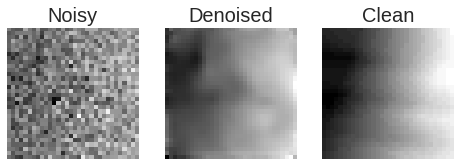

In [15]:
plot_denoise(denoise_model)


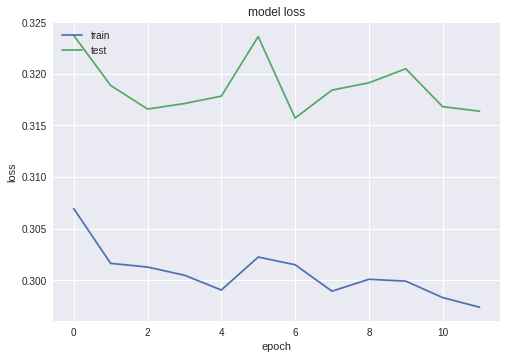

In [16]:
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:

import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Add
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt


def get_denoise_model_add(shape):

  inputs = Input(shape)
  conv1_1 = Conv2D(4, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1_3 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1_5 = Conv2D(4, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1_7 = Conv2D(4, 7, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)

  conv1 = concatenate([
      conv1_1,
      conv1_3,
      conv1_5,
      conv1_7
  ], axis = -1)

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ## Bottleneck
  conv2_1 = Conv2D(8, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2_3 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2_5 = Conv2D(8, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2_7 = Conv2D(8, 7, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  conv2 = concatenate([
      conv2_1,
      conv2_3,
      conv2_5,
      conv2_7
  ], axis = -1)  
  
  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
               #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),

  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
                 #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001),


  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_unet = Model(inputs = inputs, outputs = conv4)
  return shallow_unet


# get model
shape = (32, 32, 1)
denoise_model_add = get_denoise_model_add(shape)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/denoise_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

# optimiser
opt  = opt = keras.optimizers.nadam()

# loss
loss = 'mean_absolute_error'

# train network
def ssim_loss(clean,noisy):
  return 1 - tf.image.ssim(clean, noisy, max_val=1.0)

denoise_model_add.compile(loss=ssim_loss, optimizer=opt, metrics=['accuracy'])
denoise_history = denoise_model_add.fit_generator(generator=denoise_generator, epochs=EPOCHS, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)



Epoch 1/50
31179/31179 [==============================] - 1266s 41ms/step - loss: 0.3022 - acc: 2.6776e-05 - val_loss: 0.3134 - val_acc: 2.5620e-05

Epoch 00001: val_loss improved from inf to 0.31336, saving model to data/denoise_model.weights.01-0.31.hdf5
Epoch 2/50
31179/31179 [==============================] - 1271s 41ms/step - loss: 0.2954 - acc: 3.7864e-05 - val_loss: 0.3112 - val_acc: 3.0374e-05

Epoch 00002: val_loss improved from 0.31336 to 0.31118, saving model to data/denoise_model.weights.02-0.31.hdf5
Epoch 3/50
31179/31179 [==============================] - 1265s 41ms/step - loss: 0.2941 - acc: 3.3762e-05 - val_loss: 0.3097 - val_acc: 1.1298e-05

Epoch 00003: val_loss improved from 0.31118 to 0.30967, saving model to data/denoise_model.weights.03-0.31.hdf5
Epoch 4/50
31179/31179 [==============================] - 1260s 40ms/step - loss: 0.2956 - acc: 0.0317 - val_loss: 0.3201 - val_acc: 0.0513

Epoch 00004: val_loss did not improve from 0.30967
Epoch 5/50
31179/31179 [=====

In [0]:
denoise_model.save('denoise_add.h5') 
from google.colab import files
files.download('denoise_add.h5')

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


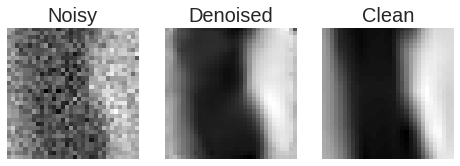

In [42]:
plot_denoise(denoise_model_add)


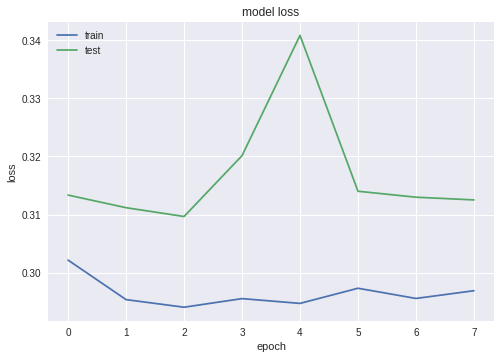

In [23]:
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt


def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  

from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [48]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))


### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)
epochs = 50
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

for e in range(epochs):
  
  descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  ### Saves optimizer and weights
  descriptor_model_trip.save('descriptor.h5') 

Using denoised patches
100%|██████████| 116/116 [00:36<00:00,  3.15it/s]
Denoising patches...
100%|██████████| 15589/15589 [04:31<00:00, 57.48it/s]


100%|██████████| 100000/100000 [00:01<00:00, 68832.10it/s]


Using denoised patches
100%|██████████| 116/116 [00:22<00:00,  4.99it/s]
Denoising patches...
100%|██████████| 9525/9525 [02:44<00:00, 57.92it/s]


100%|██████████| 10000/10000 [00:00<00:00, 68942.74it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2178

100%|██████████| 100000/100000 [00:02<00:00, 37793.68it/s]


2000/2000 [==============================] - 166s 83ms/step - loss: 0.2178 - val_loss: 0.1985
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1634

100%|██████████| 100000/100000 [00:02<00:00, 44956.53it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.1634 - val_loss: 0.1871


100%|██████████| 10000/10000 [00:00<00:00, 71424.14it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1427

100%|██████████| 100000/100000 [00:02<00:00, 43879.20it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.1427 - val_loss: 0.1927


100%|██████████| 10000/10000 [00:00<00:00, 64754.49it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1346

100%|██████████| 100000/100000 [00:02<00:00, 45075.43it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.1346 - val_loss: 0.1771


100%|██████████| 10000/10000 [00:00<00:00, 16872.36it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1288

100%|██████████| 100000/100000 [00:02<00:00, 46695.03it/s]


2000/2000 [==============================] - 161s 81ms/step - loss: 0.1287 - val_loss: 0.1794
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1226

100%|██████████| 100000/100000 [00:02<00:00, 47968.59it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.1226 - val_loss: 0.1668
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1185

100%|██████████| 100000/100000 [00:02<00:00, 36641.81it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.1186 - val_loss: 0.1622


100%|██████████| 10000/10000 [00:00<00:00, 68882.73it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1133

100%|██████████| 100000/100000 [00:02<00:00, 36120.93it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.1133 - val_loss: 0.1770
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1107

100%|██████████| 100000/100000 [00:02<00:00, 45299.58it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.1106 - val_loss: 0.1533
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1076

100%|██████████| 100000/100000 [00:02<00:00, 45953.83it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.1076 - val_loss: 0.1752
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1050

100%|██████████| 100000/100000 [00:02<00:00, 37708.26it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.1050 - val_loss: 0.1392
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1037

100%|██████████| 100000/100000 [00:02<00:00, 45866.14it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.1036 - val_loss: 0.1384
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1000

100%|██████████| 100000/100000 [00:02<00:00, 45895.52it/s]


2000/2000 [==============================] - 162s 81ms/step - loss: 0.0999 - val_loss: 0.1575


100%|██████████| 10000/10000 [00:00<00:00, 69708.03it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0995

100%|██████████| 100000/100000 [00:02<00:00, 44362.38it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.0994 - val_loss: 0.1588
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0988

100%|██████████| 100000/100000 [00:02<00:00, 46057.10it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.0988 - val_loss: 0.1260


100%|██████████| 10000/10000 [00:00<00:00, 70978.26it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0971

100%|██████████| 100000/100000 [00:02<00:00, 45324.81it/s]


2000/2000 [==============================] - 163s 81ms/step - loss: 0.0971 - val_loss: 0.1511


100%|██████████| 10000/10000 [00:00<00:00, 69920.22it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0939

100%|██████████| 100000/100000 [00:02<00:00, 45255.58it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0940 - val_loss: 0.1515


100%|██████████| 10000/10000 [00:00<00:00, 62862.67it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0911

100%|██████████| 100000/100000 [00:02<00:00, 44225.57it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0910 - val_loss: 0.1378
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0910

100%|██████████| 100000/100000 [00:02<00:00, 36600.86it/s]


2000/2000 [==============================] - 165s 82ms/step - loss: 0.0910 - val_loss: 0.1284


100%|██████████| 10000/10000 [00:00<00:00, 68296.35it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0832

100%|██████████| 100000/100000 [00:02<00:00, 36195.87it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0832 - val_loss: 0.1196
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0921

100%|██████████| 100000/100000 [00:02<00:00, 44099.67it/s]


2000/2000 [==============================] - 165s 82ms/step - loss: 0.0921 - val_loss: 0.1161


100%|██████████| 10000/10000 [00:00<00:00, 70153.64it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0822

100%|██████████| 100000/100000 [00:02<00:00, 45677.12it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0822 - val_loss: 0.1151


100%|██████████| 10000/10000 [00:00<00:00, 65499.16it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0799

100%|██████████| 100000/100000 [00:02<00:00, 36053.37it/s]


2000/2000 [==============================] - 165s 83ms/step - loss: 0.0799 - val_loss: 0.1245


100%|██████████| 10000/10000 [00:00<00:00, 63203.30it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0777

100%|██████████| 100000/100000 [00:02<00:00, 44633.33it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0778 - val_loss: 0.2005


100%|██████████| 10000/10000 [00:00<00:00, 69210.08it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0782

100%|██████████| 100000/100000 [00:02<00:00, 45490.85it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0783 - val_loss: 0.1355


100%|██████████| 10000/10000 [00:00<00:00, 68912.72it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0742

100%|██████████| 100000/100000 [00:02<00:00, 37123.99it/s]


2000/2000 [==============================] - 165s 82ms/step - loss: 0.0742 - val_loss: 0.1280


100%|██████████| 10000/10000 [00:00<00:00, 70312.17it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0760

100%|██████████| 100000/100000 [00:02<00:00, 45012.21it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0760 - val_loss: 0.1302
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0707

100%|██████████| 100000/100000 [00:02<00:00, 43481.28it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0707 - val_loss: 0.1349
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0750

100%|██████████| 100000/100000 [00:02<00:00, 44447.35it/s]


2000/2000 [==============================] - 165s 82ms/step - loss: 0.0750 - val_loss: 0.1277


100%|██████████| 10000/10000 [00:00<00:00, 70324.43it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0682

100%|██████████| 100000/100000 [00:02<00:00, 36614.49it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0682 - val_loss: 0.1210


100%|██████████| 10000/10000 [00:00<00:00, 69303.74it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0669

100%|██████████| 100000/100000 [00:02<00:00, 35546.94it/s]


2000/2000 [==============================] - 165s 82ms/step - loss: 0.0669 - val_loss: 0.1159
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0668

100%|██████████| 100000/100000 [00:02<00:00, 46717.21it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0667 - val_loss: 0.1126


100%|██████████| 10000/10000 [00:00<00:00, 69663.10it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0700

100%|██████████| 100000/100000 [00:02<00:00, 36629.37it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0700 - val_loss: 0.1170


100%|██████████| 10000/10000 [00:00<00:00, 64616.13it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0671

100%|██████████| 100000/100000 [00:02<00:00, 44791.26it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0671 - val_loss: 0.1427


100%|██████████| 10000/10000 [00:00<00:00, 64514.16it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0674

100%|██████████| 100000/100000 [00:02<00:00, 43916.53it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0673 - val_loss: 0.1091
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0647

100%|██████████| 100000/100000 [00:02<00:00, 46130.11it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0647 - val_loss: 0.1394
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0679

100%|██████████| 100000/100000 [00:02<00:00, 46059.41it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0679 - val_loss: 0.1098
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0656

100%|██████████| 100000/100000 [00:02<00:00, 38680.89it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0656 - val_loss: 0.1070


100%|██████████| 10000/10000 [00:00<00:00, 69142.54it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0671

100%|██████████| 100000/100000 [00:02<00:00, 36865.74it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0671 - val_loss: 0.1252
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0649

100%|██████████| 100000/100000 [00:02<00:00, 46066.91it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0649 - val_loss: 0.1196


100%|██████████| 10000/10000 [00:00<00:00, 66959.09it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0661

100%|██████████| 100000/100000 [00:02<00:00, 44937.63it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0661 - val_loss: 0.1402


100%|██████████| 10000/10000 [00:00<00:00, 66738.86it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0649

100%|██████████| 100000/100000 [00:02<00:00, 43363.63it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0649 - val_loss: 0.1125


100%|██████████| 10000/10000 [00:00<00:00, 14559.38it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0694

100%|██████████| 100000/100000 [00:02<00:00, 43497.93it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0693 - val_loss: 0.1347


100%|██████████| 10000/10000 [00:00<00:00, 16511.26it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0645

100%|██████████| 100000/100000 [00:02<00:00, 43232.22it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0645 - val_loss: 0.1087


100%|██████████| 10000/10000 [00:00<00:00, 16483.84it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0642

100%|██████████| 100000/100000 [00:02<00:00, 43934.52it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0642 - val_loss: 0.1171


100%|██████████| 10000/10000 [00:00<00:00, 15986.33it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0632

100%|██████████| 100000/100000 [00:02<00:00, 44214.07it/s]


2000/2000 [==============================] - 163s 82ms/step - loss: 0.0633 - val_loss: 0.1216


100%|██████████| 10000/10000 [00:00<00:00, 15594.14it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0631

100%|██████████| 100000/100000 [00:02<00:00, 45472.36it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0632 - val_loss: 0.1553
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0696

100%|██████████| 100000/100000 [00:02<00:00, 45539.39it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0696 - val_loss: 0.1050
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0624

100%|██████████| 100000/100000 [00:02<00:00, 35227.15it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0625 - val_loss: 0.1079


100%|██████████| 10000/10000 [00:00<00:00, 68963.60it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0598

100%|██████████| 100000/100000 [00:02<00:00, 35622.06it/s]


2000/2000 [==============================] - 164s 82ms/step - loss: 0.0599 - val_loss: 0.1472
